In [1]:
#Important imports
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim 
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import matplotlib.pyplot as plt

#Choosing devide to be gpu if have one, else cpu
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [2]:
class DataSet():

    def __init__(self,trainPath,testPath):  
        transformations = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
                          )
                        ])  
        self.train_data = ImageFolder(trainPath, transform = transformations)
        self.test_data = ImageFolder(testPath, transform = transformations)  
        
        self.train_loader = DataLoader(self.train_data, batch_size = 32, shuffle =True)
        self.test_loader = DataLoader(self.test_data, batch_size = 32, shuffle =True)
        
        
    def dispIMG(self,nrImg):
              plt.imshow((self.train_data[nrImg][0]).permute(1,2,0))
        
        
        
    

In [3]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # (224,224)
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2)
        
        # (112,112)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        
        self.pool2 = nn.MaxPool2d(2)
        
        # (56,56)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        
        self.pool3 = nn.MaxPool2d(2)
        # (28,28)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128*28*28,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,1)
    
    def forward(self, x):
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = self.pool3(F.relu(self.conv3(out)))
        
        out = self.flatten(out)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        
        return out

In [4]:
class CNN(DataSet):
    def __init__(self,trainPath,testPath, n_epochs,model): 
        super().__init__(trainPath,testPath)    
        
        learning_rate = 1e-3 # 0.001
        self.model = model 
        self.optimizer = optim.Adam(self.model.parameters(),lr = learning_rate)
        self.loss_fn = nn.BCELoss()  
        self.n_epochs = n_epochs 
        
        seed = 42
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        
    # Training loop for our network
    def training_loop(self, print_plot=True):

        #Initializing two lists to save accuracy to plot them later
        train_accuracy = torch.zeros(self.n_epochs)
        test_accuracy = torch.zeros(self.n_epochs)

        #Going thru every epoch
        for epoch in range(self.n_epochs):

            #Going thru example, thru every batch, in our case, thru all data at once
            for example, labels in self.train_loader:     

                #Translating calculations to gpu if is available
                example = example.to(DEVICE)
                labels = labels.to(DEVICE)

                # ensuring equal number of dimensions for labels and examples
                labels  = labels.unsqueeze(1)

                # running our data thru our data - forward
                output = self.model(example.float())
                # Getting loss of our network right now
                loss = self.loss_fn(output, labels.float())

                # Zeroing the gradient to not stack it from other iterations
                self.optimizer.zero_grad()
                #Runing backward part of the neural network, getting gradiets
                loss.backward()
                #Updating our paramters
                self.optimizer.step()


            with torch.no_grad():

                for loader, accuracy in [(self.train_loader, train_accuracy),(self.test_loader, test_accuracy)]:
                    correct = 0
                    total = 0

                    for examples, labels in loader:
                        examples = examples.to(device=DEVICE)
                        labels = labels.to(device=DEVICE).view(-1, 1)

                        outputs = self.model(examples.float())
                        predicted = torch.round(outputs)

                        total += labels.shape[0]
                        correct += (predicted == labels).sum()

                    accuracy[epoch] = correct / total

            print(f'Epoch {epoch+1})', 
                  f'Train Accuracy: {train_accuracy[epoch]}',
                  f'Test Accuracy: {test_accuracy[epoch]}')

        #If set to True, print graph of train and validation loss
        if print_plot:

            #Setting x-ticks
            epochs = range(self.n_epochs)

            #Ploting both curves, train and val 
            plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
            plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
            plt.title('Training and Test loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()    

        

    

In [5]:
model =  Net().to(DEVICE) 
NN = CNN(r'D:\__python_works\_cvc_jy\data1\train' , r'D:\__python_works\_cvc_jy\data1\test',15,model)


Epoch 1) Train Accuracy: 0.78574138879776 Test Accuracy: 0.7772727012634277
Epoch 2) Train Accuracy: 0.7887751460075378 Test Accuracy: 0.7863636016845703
Epoch 3) Train Accuracy: 0.8464163541793823 Test Accuracy: 0.8393939137458801
Epoch 4) Train Accuracy: 0.8699279427528381 Test Accuracy: 0.8454545140266418
Epoch 5) Train Accuracy: 0.9059537053108215 Test Accuracy: 0.8333333134651184
Epoch 6) Train Accuracy: 0.935912013053894 Test Accuracy: 0.831818163394928
Epoch 7) Train Accuracy: 0.9366704821586609 Test Accuracy: 0.803030252456665
Epoch 8) Train Accuracy: 0.9624573588371277 Test Accuracy: 0.831818163394928
Epoch 9) Train Accuracy: 0.9738339185714722 Test Accuracy: 0.8272727131843567
Epoch 10) Train Accuracy: 0.9920364022254944 Test Accuracy: 0.831818163394928
Epoch 11) Train Accuracy: 0.9962078332901001 Test Accuracy: 0.8272727131843567
Epoch 12) Train Accuracy: 0.9863480925559998 Test Accuracy: 0.8121212124824524
Epoch 13) Train Accuracy: 0.9992415308952332 Test Accuracy: 0.848484

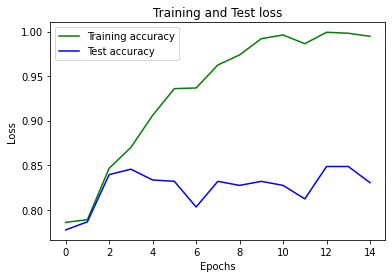

In [6]:
NN.training_loop()

In [7]:
from collections import OrderedDict

model = models.resnet50(pretrained = True)

for param in model.parameters():
    param.required_grad = False
    
nr_feat = model.fc.in_features #2048 
model.fc = nn.Sequential(OrderedDict([('fc',nn.Linear(nr_feat,1)),('sigmoid',nn.Sigmoid())])) 

model =  model.to(DEVICE) 
NN2 = CNN(r'D:\__python_works\_cvc_jy\data1\train' , r'D:\__python_works\_cvc_jy\data1\test',15,model)


Epoch 1) Train Accuracy: 0.8392112255096436 Test Accuracy: 0.8272727131843567
Epoch 2) Train Accuracy: 0.8623435497283936 Test Accuracy: 0.8348484635353088
Epoch 3) Train Accuracy: 0.8566552996635437 Test Accuracy: 0.8454545140266418
Epoch 4) Train Accuracy: 0.8581721782684326 Test Accuracy: 0.8469696640968323
Epoch 5) Train Accuracy: 0.871065616607666 Test Accuracy: 0.8545454144477844
Epoch 6) Train Accuracy: 0.8892681002616882 Test Accuracy: 0.842424213886261
Epoch 7) Train Accuracy: 0.871065616607666 Test Accuracy: 0.8606060147285461
Epoch 8) Train Accuracy: 0.9029200077056885 Test Accuracy: 0.8666666150093079
Epoch 9) Train Accuracy: 0.8991277813911438 Test Accuracy: 0.8727272748947144
Epoch 10) Train Accuracy: 0.894577145576477 Test Accuracy: 0.8560605645179749
Epoch 11) Train Accuracy: 0.8816837072372437 Test Accuracy: 0.8666666150093079
Epoch 12) Train Accuracy: 0.8957148194313049 Test Accuracy: 0.8409090638160706
Epoch 13) Train Accuracy: 0.9086082577705383 Test Accuracy: 0.860

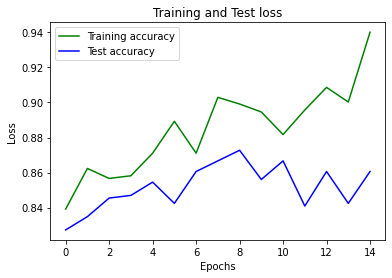

In [8]:
NN2.training_loop()